# Mini-project: Calibrated probability estimation

#### This note book comes from my coursework DSE220 at UCSD(Machine leanring).

- **Overview**:  this project is about getting `calibrated probability estimates` in classification problems.  
- **Data**: 3000 lines sentiment text data with labels 0 or 1
- **Work flow**:
    - **Step 1**: Text preprocessing
        - Text cleaning
        - Tokenize
        - Vectorize
    - **Step 2**: Fitting Support vector machine(cross-validation to select suitable slack variable)
    - **Step 3**: Calibration, learn a monotonic transformation
        - sigmoid
        - platt scaling
        - isotonic regression
    - **Step 4**: Visualize result and Conclusion

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import digits, punctuation
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

%matplotlib inline
plt.style.use('seaborn-whitegrid')

### Step 1: Text preprocessing

We will use the sentiment data which contains 3000 lines, each with one sentence followed by a label (0 or 1). 

In [4]:
s = pd.read_csv('full_set.txt', header=None, sep='\t', names=['sentence', 'label'])

- #### Remove the labels from the sentences and store them separately.

In [5]:
label = s.pop('label')
y = label.values

- #### Remove digits and punctuation, and make everything lowercase.

In [6]:
# remove punctuation
s['sentence'] = s['sentence'].apply(lambda x: x.translate(str.maketrans('', '', punctuation)))
# remove digits
s['sentence'] = s['sentence'].apply(lambda x: x.translate(str.maketrans('', '', digits)))
# lowercase strings
s['sentence'] = s['sentence'].apply(lambda x: x.lower())

- #### Remove “stop words”, common words that are useless for classification. 

In [7]:
stopwords = ['the','a','an','i','he','she','they','to','of','it','from']
s['sentence'] = s['sentence'].apply(\
        lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [8]:
# check text after preprocessing
s

,sentence
0,so there is no way for me plug in here in us u...
1,good case excellent value
2,great for jawbone
3,tied charger for conversations lasting more th...
4,mic is great
...,...
2743,just got bored watching jessice lange take her...
2744,unfortunately any virtue in this films product...
2745,in word is embarrassing
2746,exceptionally bad


- #### Vectorize: Bag-of-words

In [9]:
corpus = s['sentence'].values

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus).toarray()

# add 1 to the end of each row to represente intercepts
b = np.ones((X.shape[0], 1))
X_b = np.hstack((X, b))

# check output
X_b.shape

(2748, 5001)

- #### Divide the 3000 data points into a training set of size 2200, a calibration set of size 400, and a test set of size 400. Keep the classes balanced (each set should be evenly split between positives and negatives).

In [10]:
X_train, X_, y_train, y_ = train_test_split(X_b, y, test_size=4/15, stratify=y, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_, y_, test_size=0.5, stratify=y_, random_state=42)

print(f"Dimension of X_train: {X_train.shape}")
print(f"Dimension of y_train: {y_train.shape}")
print(f"Dimension of X_calib: {X_calib.shape}")
print(f"Dimension of y_calib: {y_calib.shape}")
print(f"Dimension of X_test: {X_test.shape}")
print(f"Dimension of y_test: {y_test.shape}")

Dimension of X_train: (2015, 5001)
Dimension of y_train: (2015,)
Dimension of X_calib: (366, 5001)
Dimension of y_calib: (366,)
Dimension of X_test: (367, 5001)
Dimension of y_test: (367,)


### Step 2: Fitting Support vector machine(cross-validation to select suitable slack variable)

In [14]:
def cross_valid(C):
    score = []
    for c in C:
        svc = LinearSVC(C=c, max_iter=10000)
        clf = svc.fit(X_train, y_train)
        score.append(1-np.mean(cross_val_score(clf, X_train, y_train, cv=5)))
    return score

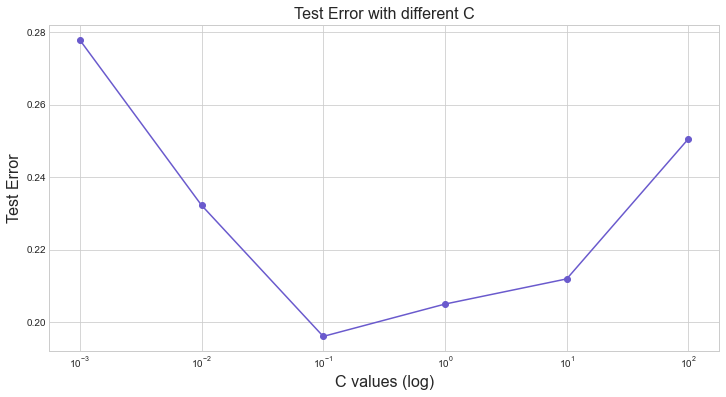

In [15]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
err = cross_valid(C)

fig = plt.figure(figsize=(12, 6))
plt.plot(C, err, '-ok', color='slateblue')
plt.xscale('log')
plt.title('Test Error with different C', fontsize=16)
plt.xlabel('C values (log)', fontsize=16)
plt.ylabel('Test Error', fontsize=16);

Best C is 0.1 for training set.

In [18]:
svc = LinearSVC(max_iter=10000, C=0.1).fit(X_train, y_train)
print(f"Error rate on test set: {1-svc.score(X_test, y_test)}")

Error rate on test set: 0.16893732970027253


### Step 3: Learning a monotonic transformation

We now have a fixed classifier: the label for $x$ is $sign(w · x + b)$. We will think of the score on point $x$
as $z(x) = w · x + b$. We want to convert these real-valued scores into probabilities, using a monotonically
increasing function $f$: we will predict $Pr(y = 1|x) = f(z(x))$. We will investigate three choices for $f$.

- Option 1: `The squashing function`. This involves no learning: map score $z$ to probability $1/(1+e^{-z})$

- Option 2: `Platt scaling`. We will map score $z$ to probability $1/(1+e^{-(az+b)})$. Hence $a,b \in \mathbb{R}$ are parameters to be learned using the calibration set, using maximum-likelihood. That is, we want to find $a, b$ to minimize
$$\sum_{(x,y)\in C} \ln(1+exp(-y(az(x)+b)))$$
where $C$ is the calibration set, assuming labels are $±1$. Since $z(x)\in R$, this is essentially a one-dimensional logistic regression problem, with data $\{(z(x),y):(x,y) \in C\}$, and can be solved easily, in 1-2 lines, using `sklearn.linear_model.LogisticRegression`.

- Option 3: Isotonic regression. The idea is to learn a general monotonic function $f : \mathbb{R} -> [0, 1]$ from scores to probabilities. The data will be $\{(z(x), y) : (x, y) \in C\}$, assuming the labels are $y \in \{0, 1\}$ (not $±1$). Suppose $Z$ is a vector of $z$-values of the calibration set, and $Y$ is a vector of corresponding 0-1 labels. (Both are $400$-dimensional vectors.)
To learn the monotonic transform:
~~~python
from sklearn.isotonic import IsotonicRegression
isotonic_clf = IsotonicRegression(out_of_bounds=’clip’)
isotonic_clf.fit(Z,Y)
~~~

To get probabilities for points in the test set, let $Z^*$ be the vector of test set scores. Use:
~~~python
test_probs = isotonic_clf.transform(Z_star)
~~~

In [20]:
class CalibratedEstimator():
    
    def __init__(self, clf, option, forcing=False):
        self.clf = clf
        self.option = option # which option to calibrate
        self.forcing = forcing # forcing intercept b = 0 or not
        
    def __z_score(self, X):
        mean = np.mean(X)
        stdev = np.std(X)
        return (X - mean)/stdev
        
    def __z(self, X, w):
        return np.dot(X, w.T)
    
    def __sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def __platt_scaling(self, X, a, b):
        return 1/(1+np.exp(-(a*X + b)))
        
        
    def pre_train(self, X_train, y_train):
        """Calculate coefficients trained by pre-defined classifier
        """
        if self.forcing == True:
            X_train = X_train[:, :-1] # ensure intercepts are 0
        
        self.clf.fit(X_train, y_train)
        self.w = self.clf.coef_
        return self
        
    
    def fit(self, X_calib, y_calib):
        """Fit monotonic transformation with options
        """
        if self.forcing == True:
            X_calib = X_calib[:, :-1]
        z_calib = self.__z(X_calib, self.w)
        
        if self.option == 'platt_scaling':    
            lr = LogisticRegression().fit(z_calib, y_calib)
            self.a, self.b = lr.coef_, lr.intercept_
        elif self.option == 'isotonic':
            Z_c = self.__z_score(z_calib) # calculate Z-score (calib set)
            Z_c = Z_c.reshape((Z_c.shape[0],))
            self.iso = IsotonicRegression(out_of_bounds='clip').fit(Z_c, y_calib)
            
        return self
    
    
    def predict_proba(self, X_test):
        """Predict confidence score based on calibrated coefficients
        """
        if self.forcing == True:
            X_test = X_test[:, :-1]
        z_test = self.__z(X_test, self.w)
        
        if self.option == 'sigmoid':
            prob_pred = self.__sigmoid(z_test)
        elif self.option == 'platt_scaling':
            prob_pred = self.__platt_scaling(z_test, self.a, self.b)
        elif self.option == 'isotonic':
            Z_t = self.__z_score(z_test) # calculate Z-score (test set)
            Z_t = Z_t.reshape((Z_t.shape[0],))
            prob_pred = self.iso.transform(Z_t)
            
        return prob_pred
    
    
    def predict(self, X_test):
        if self.forcing == True:
            X_test = X_test[:, :-1]
        prob = self.predict_proba(X_test)
        label_pred = np.asarray([1 if i >= 0.5 else 0 for i in prob])
        return label_pred

### Step 4: Visualize result and Conclusion

In [21]:
def plot_reliability_diag():
    calibrators = ['sigmoid', 'platt_scaling', 'isotonic']

    fig = plt.figure(figsize=(12, 12))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for c in calibrators:
        calibrator = CalibratedEstimator(svc, f'{c}').pre_train(X_train, y_train)
        calibrator.fit(X_calib, y_calib)
        y_pred = calibrator.predict_proba(X_test)
        mean_predicted_value, fraction_of_positives = calibration_curve(y_test, y_pred, n_bins=10)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"SVC + {c}")
        ax2.hist(y_pred, range=(0, 1), bins=10, label=f"SVC + {c}", histtype="step", lw=2)
    
    platt_no_b = CalibratedEstimator(svc, 'platt_scaling', forcing=True).pre_train(X_train, y_train)
    platt_no_b.fit(X_calib, y_calib)
    y_pred_no_b = platt_no_b.predict_proba(X_test)
    mean_predicted_value_no_b, fraction_of_positives_no_b = calibration_curve(y_test, y_pred_no_b, n_bins=10)
    ax1.plot(mean_predicted_value_no_b, fraction_of_positives_no_b, "s-", label="SVC + platt(b=0)")
    ax2.hist(y_pred_no_b, range=(0, 1), bins=10, label=f"SVC + platt(b=0)", histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives", fontsize=16)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right", fontsize=16)
    ax1.set_title('Calibration plots  (reliability curve)', fontsize=16)

    ax2.set_xlabel("Mean predicted value", fontsize=16)
    ax2.set_ylabel("Count", fontsize=16)
    ax2.legend(loc="upper center", ncol=2, fontsize=16)

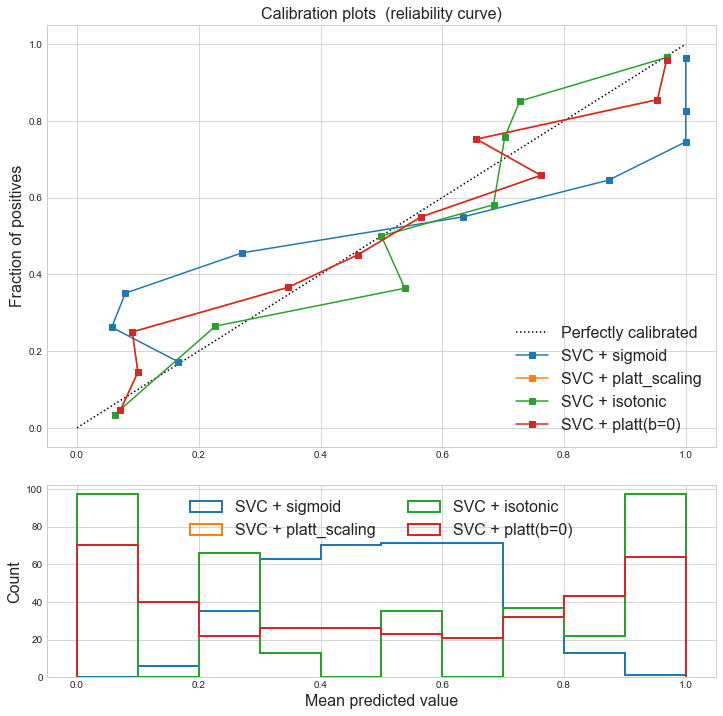

In [22]:
plot_reliability_diag()

### Conclusion

-  For `sigmoid function`, calibration did not happen, since the squashing function just transforms real-valued scores $z(x)$ to a range of $[0, 1]$.

-  From the plot above, we conclude that the reliability curve for `platt scaling` with b overlaps the curve that forcing b=0, which indicates that the intercept does not affect the calibration result, meanwhile, platt scaling does a better calibration than option 1, as we can see its reliability curve is much closer to perfectly calibrated line.

-  Compared to platt scaling, isotonic regression does not perform better here.

-  Whether to choose platt scaling or istonic regression, it depends on the situation, isotonic regression is suitable for a bigger calibration set.

-  For multiclass predictions, each class was calibrated separately in a OneVsRestClassifier fashion. When predicting probabilities, the calibrated probabilities for each class are predicted separately. As those probabilities do not necessarily sum to one, a postprocessing is performed to normalize them. 
    References:https://scikit-learn.org/stable/modules/calibration.html